# Lab Session: Movie Recommendations

![LDF Logo](http://grouplens.org/site-content/uploads/ml-logo.png)

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)

## Introduction

* In the theory lesson on Recommender systems we saw a number of algorithms which we will be able to use to recommend movies based on your own provided data.

* The MovieLens 1M dataset can be found <a href="http://grouplens.org/datasets/movielens/"> here </a>

    * `wget http://files.grouplens.org/datasets/movielens/ml-1m-README.txt`
    * `wget http://files.grouplens.org/datasets/movielens/ml-1m.zip`
    * `unzip ml-1m.zip`


* <b>Have a look at the README's to understand the meaning of the different fields!!!</b>

* Later in [Exerice 2](#Exercise-2:-Connecting-your-IMDB-ratings-to-MovieLens), we will use personalized movie ratings to create recommendations (IMDB dataset). The file `MovieSurvey_userrating.xlsx` is available from Minerva, you can modify it to account for movies you've seen and your own ratings, or use the current ratings of a random user as is. These scores will be blended with the MovieLens dataset. Make sure to save the file `MovieSurvey_userrating` in `csv` format after modifying it.

* We will work a lot with distributed dataframes in this lab, the programming guide can be found <a href="http://spark.apache.org/docs/latest/sql-getting-started.html"> here.


Naming convention for the datasets in this lab:
* <b>MovieLens</b> = 1M movie ratings 
* <b>IMDB dataset</b> = the set of 100 movies with your personal ratings (convert to CSV-format!)


In [1]:
import pyspark
try:
    sc = pyspark.SparkContext('local[*]')
except:
    pass

# necessary to use matplotlib in a notebook
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.ticker as mtick
import pandas as pd
import re

In [2]:
# Note: SparkSession has been introduced in the Spark 2.0 API, the previous api used sqlContext, it can still be used but is deprecated
from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder.getOrCreate()

* Load the Movielens files into Distributed Dataframes, set the column names properly 

* PROBLEM: some movie titles have ':' symbols in them!!! => preprocessing will be needed! (csv function only support single character delimiters)
* To convert between RDD and DDF have a look at **Inferring the Schema Using Reflection** in the getting started guide.

In [3]:
# Movies
# MovieID::Title::Genres => # 1::Toy Story (1995)::Animation|Children's|Comedy
movies_ddf = spark.createDataFrame(sc.textFile('ml-1m/movies.dat')
                  .map(lambda l: l.split("::"))
                  .flatMap(lambda p: [Row(MovieID=p[0], Title=p[1], Genre=x) for x in p[2].split("|")])
             )
movies_ddf.cache()
movies_ddf.show(5)

+----------+-------+----------------+
|     Genre|MovieID|           Title|
+----------+-------+----------------+
| Animation|      1|Toy Story (1995)|
|Children's|      1|Toy Story (1995)|
|    Comedy|      1|Toy Story (1995)|
| Adventure|      2|  Jumanji (1995)|
|Children's|      2|  Jumanji (1995)|
+----------+-------+----------------+
only showing top 5 rows



In [4]:
# Ratings
# UserID::MovieID::Rating::Timestamp => example: 1::1193::5::978300760   
ratings_ddf = spark.createDataFrame(sc.textFile('ml-1m/ratings.dat')
                   .map(lambda l: l.split("::"))
                   .map(lambda p: Row(UserID=p[0], MovieID=p[1], Rating=p[2], Timestamp=p[3]))
              )
ratings_ddf.cache()
ratings_ddf.show(5)

+-------+------+---------+------+
|MovieID|Rating|Timestamp|UserID|
+-------+------+---------+------+
|   1193|     5|978300760|     1|
|    661|     3|978302109|     1|
|    914|     3|978301968|     1|
|   3408|     4|978300275|     1|
|   2355|     5|978824291|     1|
+-------+------+---------+------+
only showing top 5 rows



In [5]:
# Users
# UserID::Gender::Age::Occupation::Zip-code  NOTE age is in segments: 1,18,25,35,45,50,56 , occupation: 0 - 20
users_ddf = spark.createDataFrame(sc.textFile('ml-1m/users.dat')
                 .map(lambda l: l.split("::"))
                 .map(lambda p: Row(UserID=p[0], Gender=p[1], Age=p[2], Occupation=p[3], Zipcode=p[4])) #Zip-code without '-'
            )
users_ddf.cache()    
users_ddf.show(5)

+---+------+----------+------+-------+
|Age|Gender|Occupation|UserID|Zipcode|
+---+------+----------+------+-------+
|  1|     F|        10|     1|  48067|
| 56|     M|        16|     2|  70072|
| 25|     M|        15|     3|  55117|
| 45|     M|         7|     4|  02460|
| 25|     M|        20|     5|  55455|
+---+------+----------+------+-------+
only showing top 5 rows



## Exercise 1: Data exploration

For the dataframes API have a look here: http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame


* **NOTE** NO RDDs => work with DataFrames only, it 'll save you a lot of time later on!

#### 1a. How many users are present in the data, how many movies?



In [6]:
print("Number of users: " + str(users_ddf.count()))
print("Number of ratings: " + str(ratings_ddf.count()))

Number of users: 6040
Number of ratings: 1000209


#### 1b. Draw a barplot showing the distribution of scores in the MovieLens dataset.


Text(0, 0.5, 'number of ratings')

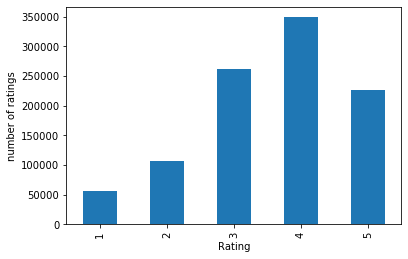

In [7]:
df = (ratings_ddf.groupBy('Rating')
                 .count()
                 .sort('Rating')
                 .toPandas())
ax = df.plot(x='Rating', y='count', kind="bar", legend=False)
ax.set_ylabel("number of ratings")

#### 1c. Study the distribution of the number of ratings per movie. Can you recreate the long tail as expected? What are the max and minimum number of views?


Maximum number of views: 3428
Minimum number of views: 1


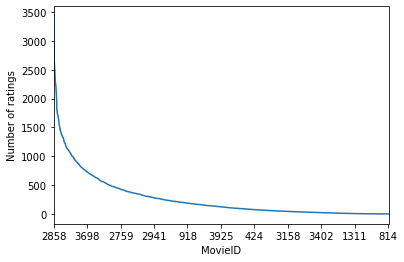

In [8]:
df = (ratings_ddf.groupBy('MovieID')
                 .count()
                 .sort('count', ascending=False)
                 .toPandas())
ax = df.plot(x='MovieID', y='count', legend=False)
ax.set_ylabel("Number of ratings")
ax.set_xticks(list(range(0, len(df.MovieID), len(df.MovieID)//10))) 
ax.set_xticklabels([df.MovieID.tolist()[i] for i in range(0, len(df.MovieID), len(df.MovieID)//10)])

print("Maximum number of views: " + str(df.iloc[0]['count']))
print("Minimum number of views: " + str(df.iloc[-1]['count']))

#### 1d. What are the different genre tags in the MovieLens data. Draw a bar plot showing the percentage of movies in which each tag occurs. NOTE: here it makes sense to make a detour using RDDs

* Note: Check if there are any movies without genre tags, this verifies if your datasets where loaded properly

Movies without genre tags: 0
Number of distinct tags: 18
Number of movies: 6408


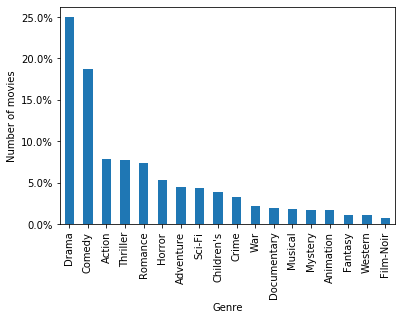

In [9]:
print("Movies without genre tags: " + str((movies_ddf[movies_ddf.Genre == ""]).count()))
print("Number of distinct tags: " + str(len((movies_ddf.toPandas()).Genre.unique())))
print("Number of movies: " + str(movies_ddf.count()))

tag_distribution = (movies_ddf.groupBy('Genre')
                              .count()
                              .sort('count', ascending=False)
                              .toPandas())
tag_distribution['count'] = tag_distribution['count'].div(movies_ddf.count()/100)
ax = tag_distribution.plot(x='Genre', y='count', kind="bar", legend=False)
ax.set_ylabel("Number of movies")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Exercise 2: Connecting your IMDB ratings to MovieLens

**IDEA:** We would like to recommend IMDB top 100 movies to you based on a recommender system trained on the full Movielens dataset. 

* Challenge: It's nontrivial to link the two datasets together since no join key is present!
* Inspiration: You can borrow some ideas from the lesson on Google: matching NLP queries to documents

#### Linking the movies in the IMBD dataset present to the movies in the Movielens dataset? 

Create a (distributed) dataframe  IMDB_df containing the information in your personal IMDB CSV. Next try and find the movieIDs in the MovieLens dataset which correspond to the movies in the IMBD_df. Only keep movies in IMBD_df which are succesfully linked. This will not be all the movies since MovieLens only has movies which were released before the year 2000. 

In [10]:
IMDB_df = spark.read.option("delimiter", ";").csv('MovieSurvey_userrating.csv', header=True)
IMDB_df.show(5)

+---+--------------------+--------------------+---------+---------+----+-----+
| id|               Title|                Tags|ImdbScore|Evaluator|Seen|Score|
+---+--------------------+--------------------+---------+---------+----+-----+
|  1|The Shawshank Red...|         Crime,Drama|      9.2|     User|   0|    0|
|  2|       The Godfather|         Crime,Drama|      9.2|     User|   1|  7.5|
|  3|The Godfather: Pa...|         Crime,Drama|        9|     User|   1|  7.5|
|  4|        Pulp Fiction|Crime,Drama,Thriller|      8.9|     User|   1|    8|
|  5|    Schindler's List|Biography,Drama,H...|      8.9|     User|   1|  8.5|
+---+--------------------+--------------------+---------+---------+----+-----+
only showing top 5 rows



<b> GOAL: </b> Engineer a join_key so that you can link the movieIDs in Movielens to the movietitles in the IMBD dataset. 

* Note1: This is quite hard, MovieLens is a human-created dataset so it contains errors, but you should be able to find a reasonable overlap, say approximately 2/3 of the IMBD movie titles.

* Note2: Edge case: There are cases where movies have the same title, in that case assume the IMDB  movie corresponds to the original release (oldest).

* Note3: To have an idea: using rather simple tricks I managed to join 64 IMDB movies with the MovieLens dataset. Can you do better?

**TIP:** Creating user-defined functions: http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf


In [11]:
from pyspark.sql.functions import udf

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

<b>TIP1</b>: the columns in the final dataframe should contain a column for the title in IMDB and one for the column in MovieLens, this will allow you to validate that your joins are in fact correct.

<b>TIP2</b>: to run a lambda function on a column you need to transform the function to a udf (user-defined function)

<b>TIP3</b>: have a look at the documentation as to why we imported 'functions' and 'types'?


### 2a. Add a joinkey column for the IMDB_df

In [12]:
from pyspark.sql.types import StringType
stopwords = ["ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", 
             "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into",
             "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", 
             "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", 
             "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", 
             "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", 
             "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", 
             "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", 
             "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", 
             "how", "further", "was", "here", "than"]

def remove_stopwords(x):
    l = x.split(' ')
    for word in l:
        if (word in stopwords):
            l.remove(word)
    return ' '.join(l)

remove_stopwords_udf = udf(remove_stopwords, StringType())

# add a joinkey column
IMDB_df = IMDB_df.withColumn('joinkey', F.lower(F.col("Title")))
IMDB_df = IMDB_df.withColumn('joinkey', remove_stopwords_udf(F.col('joinkey')))
IMDB_df = IMDB_df.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), ":", ""))
IMDB_df = IMDB_df.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), ",", ""))
IMDB_df = IMDB_df.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), "'", ""))
IMDB_df = IMDB_df.withColumn('joinkey', F.trim(F.col('joinkey')))

# rename column title
IMDB_df = IMDB_df.select(F.col("id").alias("IMDB_id"),F.col("Title").alias("IMDB_title"), 
                         F.col("Tags").alias("IMDB_tags"), F.col("ImdbScore"), F.col("Evaluator"),
                         F.col("Seen"), F.col("Score"), F.col("joinkey"))
IMDB_df.show(5)

+-------+--------------------+--------------------+---------+---------+----+-----+--------------------+
|IMDB_id|          IMDB_title|           IMDB_tags|ImdbScore|Evaluator|Seen|Score|             joinkey|
+-------+--------------------+--------------------+---------+---------+----+-----+--------------------+
|      1|The Shawshank Red...|         Crime,Drama|      9.2|     User|   0|    0|shawshank redemption|
|      2|       The Godfather|         Crime,Drama|      9.2|     User|   1|  7.5|           godfather|
|      3|The Godfather: Pa...|         Crime,Drama|        9|     User|   1|  7.5|   godfather part ii|
|      4|        Pulp Fiction|Crime,Drama,Thriller|      8.9|     User|   1|    8|        pulp fiction|
|      5|    Schindler's List|Biography,Drama,H...|      8.9|     User|   1|  8.5|     schindlers list|
+-------+--------------------+--------------------+---------+---------+----+-----+--------------------+
only showing top 5 rows



### 2b. Add a joinkey column for the movielens dataframe

In [13]:
def remove_year(x):
    return x[:x.find("(")-1] #also remove last space

remove_year_udf = udf(remove_year, StringType())

# add a joinkey column
movies_ddf = movies_ddf.withColumn('joinkey',F.lower(F.col("Title")))
movies_ddf = movies_ddf.withColumn('joinkey', remove_stopwords_udf(F.col('joinkey')))
movies_ddf = movies_ddf.withColumn('joinkey', remove_year_udf(F.col('joinkey')))
movies_ddf = movies_ddf.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), ":", ""))
movies_ddf = movies_ddf.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), ",", ""))
movies_ddf = movies_ddf.withColumn('joinkey', F.regexp_replace(F.col('joinkey'), "'", ""))
movies_ddf = movies_ddf.withColumn('joinkey', F.trim(F.col('joinkey')))

movies_ddf.show(5)

+----------+-------+----------------+---------+
|     Genre|MovieID|           Title|  joinkey|
+----------+-------+----------------+---------+
| Animation|      1|Toy Story (1995)|toy story|
|Children's|      1|Toy Story (1995)|toy story|
|    Comedy|      1|Toy Story (1995)|toy story|
| Adventure|      2|  Jumanji (1995)|  jumanji|
|Children's|      2|  Jumanji (1995)|  jumanji|
+----------+-------+----------------+---------+
only showing top 5 rows



### 2c. Join the dataframes together using your engineered joinkeys, eliminated duplicate matches!

**TIP:** http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join

In [14]:
df_joined = (movies_ddf.join(IMDB_df,'joinkey','inner')
                       .select("MovieID","Title","IMDB_title", "ImdbScore", "Seen", "Score", "joinkey")
            )
df_joined = df_joined.orderBy("Title").dropDuplicates(["IMDB_title"]) # sort to make sure oldest(original) movie matches
df_joined.show(5)

print(str(df_joined.count()), " movies could be matched")

+-------+--------------------+------------------+---------+----+-----+------------------+
|MovieID|               Title|        IMDB_title|ImdbScore|Seen|Score|           joinkey|
+-------+--------------------+------------------+---------+----+-----+------------------+
|    912|   Casablanca (1942)|        Casablanca|      8.6|   0|    0|        casablanca|
|   2329|American History ...|American History X|      8.6|   1|  8.5|american history x|
|   1225|      Amadeus (1984)|           Amadeus|      8.3|   1|    8|           amadeus|
|   3578|    Gladiator (2000)|         Gladiator|      8.5|   1|  7.5|         gladiator|
|   1219|       Psycho (1960)|            Psycho|      8.6|   1|  8.5|            psycho|
+-------+--------------------+------------------+---------+----+-----+------------------+
only showing top 5 rows

58  movies could be matched


#### 2d. Filter the previous dataframe to only contain records you have actually rated + transform the rating from [0,10] range to [1,5] stars

In [15]:
def calculate_stars(x):
    return int(float(x)//2)

calculate_stars_udf = udf(calculate_stars, IntegerType())

df_imdb_rated = df_joined.filter(F.col('Seen') == '1')
df_imdb_rated = df_imdb_rated.withColumn('stars', calculate_stars_udf(F.col('Score')) )

df_imdb_rated.show(n=5)
print(df_imdb_rated.count(), "movies are rated")

+-------+--------------------+------------------+---------+----+-----+------------------+-----+
|MovieID|               Title|        IMDB_title|ImdbScore|Seen|Score|           joinkey|stars|
+-------+--------------------+------------------+---------+----+-----+------------------+-----+
|   2329|American History ...|American History X|      8.6|   1|  8.5|american history x|    4|
|   1225|      Amadeus (1984)|           Amadeus|      8.3|   1|    8|           amadeus|    4|
|   3578|    Gladiator (2000)|         Gladiator|      8.5|   1|  7.5|         gladiator|    3|
|   1219|       Psycho (1960)|            Psycho|      8.6|   1|  8.5|            psycho|    4|
|   1258| Shining, The (1980)|       The Shining|      8.4|   1|  9.5|           shining|    4|
+-------+--------------------+------------------+---------+----+-----+------------------+-----+
only showing top 5 rows

29 movies are rated


## Exercise 3: Static (segment-based) recommendations 

#### 3a. What's the top 10 of movies with the highest number of views? (show the titles as well)


In [16]:
ddf = ratings_ddf.join(movies_ddf, 'MovieID', 'inner').select('MovieID', movies_ddf.Title, ratings_ddf.UserID).dropDuplicates()

most_views_top10 = (ddf.groupBy('MovieID', 'Title')
                       .count()
                       .orderBy('count', ascending=False)
                       .limit(10)
                   )
most_views_top10.show()

+-------+--------------------+-----+
|MovieID|               Title|count|
+-------+--------------------+-----+
|   2858|American Beauty (...| 3428|
|    260|Star Wars: Episod...| 2991|
|   1196|Star Wars: Episod...| 2990|
|   1210|Star Wars: Episod...| 2883|
|    480|Jurassic Park (1993)| 2672|
|   2028|Saving Private Ry...| 2653|
|    589|Terminator 2: Jud...| 2649|
|   2571|  Matrix, The (1999)| 2590|
|   1270|Back to the Futur...| 2583|
|    593|Silence of the La...| 2578|
+-------+--------------------+-----+



In [17]:
users_male = users_ddf.filter(users_ddf['Gender'] == 'M')
users_female = users_ddf.filter(users_ddf['Gender'] == 'F')

#### 3b. What's the top 10 of movies based on average rating and with at least 100 views, distinguish between a top 10 for men and for women? How many movies do both rankings have in common?

In [35]:
ddf = users_male.join(ratings_ddf, 'UserID', 'inner').select('UserID', ratings_ddf.MovieID, ratings_ddf.Rating).dropDuplicates()
ddf = ddf.join(movies_ddf, 'MovieID', 'inner').select('MovieID', ddf.UserID, ddf.Rating, movies_ddf.Title).dropDuplicates()
ddf = (ddf.groupBy('MovieID', 'Title')
          .agg(F.mean('Rating'), F.count('Rating'))
      )
top10_males_titles = (ddf.filter(ddf['count(Rating)'] >= 100)
                .orderBy('avg(Rating)', ascending=False)
                .limit(10)
            )
print('MALES:')
top10_males_titles.show()

ddf = users_female.join(ratings_ddf, 'UserID', 'inner').select('UserID', ratings_ddf.MovieID, ratings_ddf.Rating).dropDuplicates()
ddf = ddf.join(movies_ddf, 'MovieID', 'inner').select('MovieID', ddf.UserID, ddf.Rating, movies_ddf.Title).dropDuplicates()
ddf = (ddf.groupBy('MovieID', 'Title')
          .agg(F.mean('Rating'), F.count('Rating'))
      )
top10_females_titles = (ddf.filter(ddf['count(Rating)'] >= 100)
                .orderBy('avg(Rating)', ascending=False)
                .limit(10)
            )
print('FEMALES:')
top10_females_titles.show()

MALES:
+-------+--------------------+-----------------+-------------+
|MovieID|               Title|      avg(Rating)|count(Rating)|
+-------+--------------------+-----------------+-------------+
|    858|Godfather, The (1...|4.583333333333333|         1740|
|   2019|Seven Samurai (Th...|4.576628352490421|          522|
|    318|Shawshank Redempt...|         4.560625|         1600|
|   1198|Raiders of the Lo...|4.520597322348094|         1942|
|     50|Usual Suspects, T...|4.518248175182482|         1370|
|    260|Star Wars: Episod...|4.495307167235495|         2344|
|    527|Schindler's List ...| 4.49141503848431|         1689|
|   1178|Paths of Glory (1...|4.485148514851486|          202|
|   1148|Wrong Trousers, T...|4.478260869565218|          644|
|    745|Close Shave, A (1...|4.473794549266247|          477|
+-------+--------------------+-----------------+-------------+

FEMALES:
+-------+--------------------+-----------------+-------------+
|MovieID|               Title|      av

In [19]:
in_common = top10_males_titles.join(top10_females_titles, ['MovieID', 'Title'], 'inner').select('MovieID', 'Title')
in_common.show()

print("In common: " + str(in_common.count()))

+-------+--------------------+
|MovieID|               Title|
+-------+--------------------+
|    318|Shawshank Redempt...|
|     50|Usual Suspects, T...|
|    527|Schindler's List ...|
|   1148|Wrong Trousers, T...|
|    745|Close Shave, A (1...|
+-------+--------------------+

In common: 5


## Exercise 4: Latent-factor approach

* Have a look at the Spark ML documentation about Collaborative filtering: http://spark.apache.org/docs/latest/ml-collaborative-filtering.html

* API documentation for the ALS algorithm: http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.recommendation.ALS

#### 4a. Run the ALS recommender algorithm on the Movielens dataset and project & visualize the movies in a 2D latent space 

* Prepare dataframe for ALS algorithm (column names)
* Map the ratings to [-1,1], this will improve the ALS projection

In [20]:
from pyspark.ml.recommendation import ALS

In [21]:
ratings_prepared = ratings_ddf.select(ratings_ddf.MovieID.cast('int').alias("item"), ratings_ddf.Rating.cast('int').alias("rating"), ratings_ddf.UserID.cast('int').alias("user"))
ratings_prepared.show(5)

+----+------+----+
|item|rating|user|
+----+------+----+
|1193|     5|   1|
| 661|     3|   1|
| 914|     3|   1|
|3408|     4|   1|
|2355|     5|   1|
+----+------+----+
only showing top 5 rows



In [22]:
def map_ratings(x):
    return ((float(x)/5.0)*2.0)-1

map_ratings_udf = udf(map_ratings, FloatType())

ratings_mapped = ratings_prepared.withColumn('rating', map_ratings_udf(F.col('rating')) )

ratings_mapped.show(5)

+----+------+----+
|item|rating|user|
+----+------+----+
|1193|   1.0|   1|
| 661|   0.2|   1|
| 914|   0.2|   1|
|3408|   0.6|   1|
|2355|   1.0|   1|
+----+------+----+
only showing top 5 rows



* Run the ALS algorithm and extract the 2D representations of the movies

In [23]:
# run the ALS algorithm 
als = ALS(rank=2, maxIter=5, seed=0)
model = als.fit(ratings_mapped)

In [24]:
movieFeaturesDF = pd.DataFrame(model.itemFactors.collect())
movieFeaturesDF.columns = ['MovieID', 'xy']
print(movieFeaturesDF)

      MovieID                                          xy
0          10      [0.18906269967556, 0.5359545350074768]
1          20  [0.29639941453933716, 0.05038561671972275]
2          30  [-0.19136697053909302, 0.5854771137237549]
3          40   [-0.13252760469913483, 0.704698920249939]
4          50  [-0.06277841329574585, 0.9819600582122803]
...       ...                                         ...
3701     3909  [0.15391497313976288, 0.14202071726322174]
3702     3919  [0.2610200345516205, -0.11056802421808243]
3703     3929   [-0.1575295627117157, 0.7503583431243896]
3704     3939   [0.4137367606163025, -0.3811191916465759]
3705     3949  [-0.16636885702610016, 0.8057612180709839]

[3706 rows x 2 columns]


* Visualize the IMDB movies, add the movienames to the scatter plot! Put the movies you've seen in green, the one's you haven't seen in red.
* NOTE: you'll need the matching between Movielens and IMDB from exercise 2

In [25]:
movieFeaturesDF['x'] = movieFeaturesDF.apply(lambda x: x.xy[0], axis=1).astype(float)
movieFeaturesDF['y'] = movieFeaturesDF.apply(lambda x: x.xy[1], axis=1).astype(float)
movieFeaturesDF.MovieID = movieFeaturesDF.MovieID.astype(int)
movieFeaturesDF = movieFeaturesDF[['MovieID', 'x', 'y']]

In [26]:
# join with IMDB + add movie titles
movies_df = movies_ddf.toPandas()
movies_df.MovieID = movies_df.MovieID.astype(int)
joined_df = pd.merge(movieFeaturesDF, movies_df, on=['MovieID'])[['Title', 'x', 'y', 'MovieID']].drop_duplicates()
ratings_df = df_joined.toPandas()
ratings_df.MovieID = ratings_df.MovieID.astype(int)
joined_df = pd.merge(joined_df, ratings_df, on=['MovieID', 'Title'])[['MovieID', 'Title', 'x', 'y', 'Seen']]

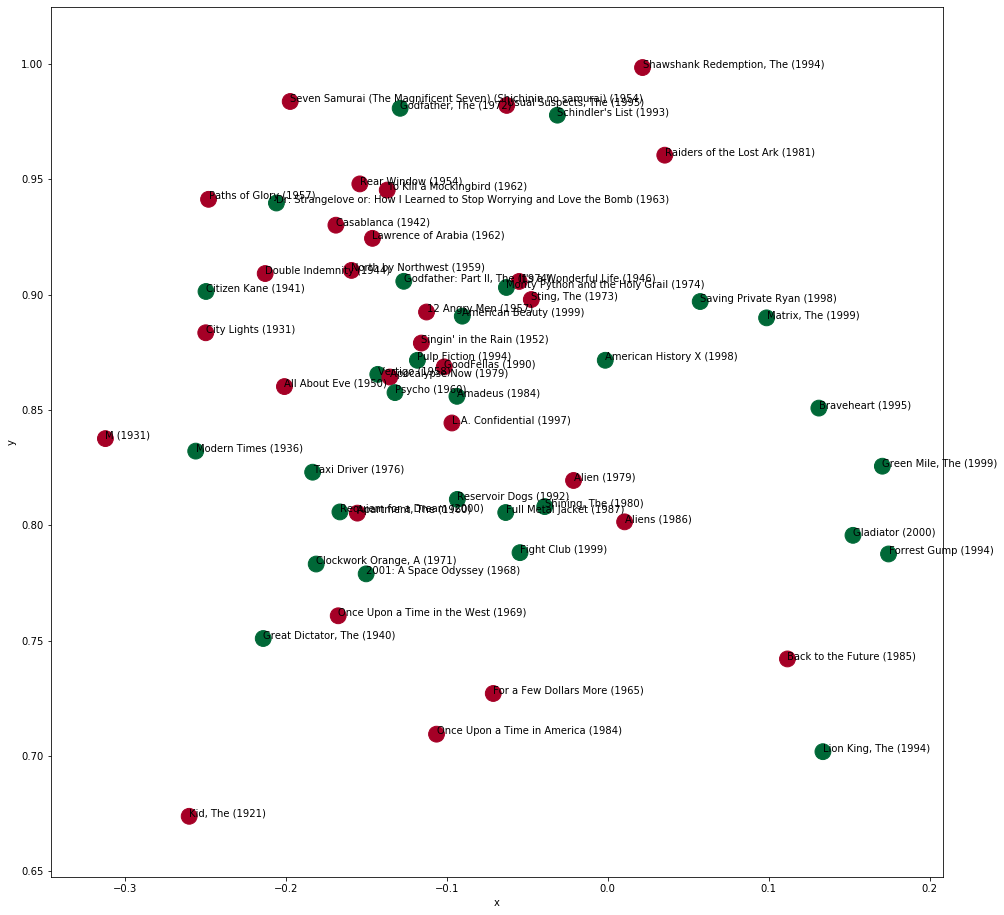

In [27]:
# back  to pandas
# already in pandas

# plot
joined_df['x'] = joined_df['x'].astype(float)
joined_df['y'] = joined_df['y'].astype(float)
joined_df['Seen'] = joined_df.Seen.astype(int)
ax = joined_df.plot.scatter(x='x', y='y', c='Seen', colormap='RdYlGn', figsize=(16,16), s=250, colorbar=False)

# add movienames to plot
joined_df[['x', 'y', 'Title']].apply(lambda row: ax.text(*row), axis=1);

### 4b. Plot the 5 most viewed movies per quadrant 

In [28]:
quadrant1 =  joined_df[(joined_df['x'] >= 0.) & (joined_df['y'] >= 0.)]
quadrant2 =  joined_df[(joined_df['x'] < 0.) & (joined_df['y'] >= 0.)]
quadrant3 =  joined_df[(joined_df['x'] < 0.) & (joined_df['y'] < 0.)]
quadrant4 =  joined_df[(joined_df['x'] >= 0.) & (joined_df['y'] < 0.)]

print("#Movies in Q1: " + str(len(quadrant1.MovieID)))
print("#Movies in Q2: " + str(len(quadrant2.MovieID)))
print("#Movies in Q3: " + str(len(quadrant3.MovieID)))
print("#Movies in Q4: " + str(len(quadrant4.MovieID)))

#Movies in Q1: 11
#Movies in Q2: 47
#Movies in Q3: 0
#Movies in Q4: 0


37    Text(-0.09037353098392487, 0.8906081318855286,...
27    Text(-0.031298454850912094, 0.9777284860610962...
30    Text(-0.0968000590801239, 0.8443105220794678, ...
32    Text(-0.12895411252975464, 0.9807100892066956,...
23    Text(-0.11823500692844391, 0.8714746832847595,...
dtype: object

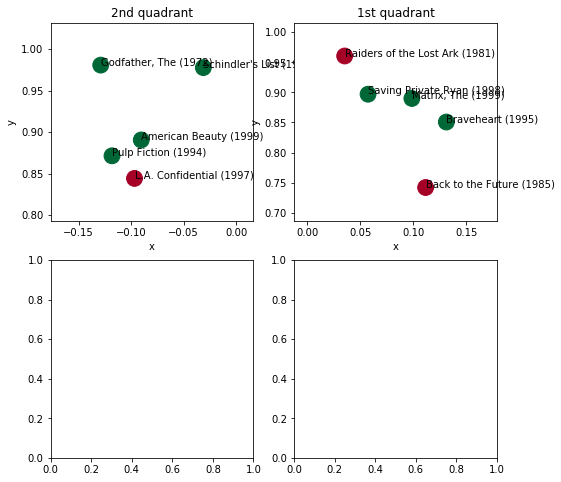

In [29]:
# plot top5 movies per quadrant
counts = ratings_ddf.groupBy("MovieID").count().toPandas()
counts['MovieID'] = counts['MovieID'].astype(int)
counts['count'] = counts['count'].astype(int)

fig, axes = plt.subplots(nrows=2, ncols=2)

df = pd.merge(quadrant1, counts, on='MovieID')
df = df.nlargest(5, 'count')
ax = df.plot.scatter(x='x', y='y', c='Seen', colormap='RdYlGn', figsize=(8,8), s=250, colorbar=False, ax=axes[0,1], title = "1st quadrant")
df[['x', 'y', 'Title']].apply(lambda row: ax.text(*row), axis=1)

df = pd.merge(quadrant2, counts, on='MovieID')
df = df.nlargest(5, 'count')
ax = df.plot.scatter(x='x', y='y', c='Seen', colormap='RdYlGn', figsize=(8,8), s=250, colorbar=False, ax=axes[0,0], title="2nd quadrant")
df[['x', 'y', 'Title']].apply(lambda row: ax.text(*row), axis=1)

# df = pd.merge(quadrant3, counts, on='MovieID')
# df = df.nlargest(5, 'count')
# ax = df.plot.scatter(x='x', y='y', figsize=(8,8), s=250, colorbar=False, ax=axes[1,0], title = "3rd quadrant")

#df = pd.merge(quadrant4, counts, on='MovieID')
#df = df.nlargest(5, 'count')
#ax = df.plot.scatter(x='x', y='y', figsize=(8,8), s=250, colorbar=False, ax=axes[1,1], title="4th quadrant")

#### 4c. What are the top 10 movies you haven't seen but you should according to the latent-factor model?

* This will require a little bit of thought, how will you enable the model to make rating predictions for YOU?

In [30]:
# make rating table for YOU -> UserID = 0
df_imdb_rated.show(5)

ddf_you = df_imdb_rated.select(df_imdb_rated.MovieID.cast('int').alias("item"), df_imdb_rated.stars.cast('int').alias("rating"))
ddf_you = ddf_you.withColumn("user", F.lit(0))
ddf_you = ddf_you.withColumn('rating', map_ratings_udf(F.col('rating')) )
ddf_you.show(5)

+-------+--------------------+------------------+---------+----+-----+------------------+-----+
|MovieID|               Title|        IMDB_title|ImdbScore|Seen|Score|           joinkey|stars|
+-------+--------------------+------------------+---------+----+-----+------------------+-----+
|   2329|American History ...|American History X|      8.6|   1|  8.5|american history x|    4|
|   1225|      Amadeus (1984)|           Amadeus|      8.3|   1|    8|           amadeus|    4|
|   3578|    Gladiator (2000)|         Gladiator|      8.5|   1|  7.5|         gladiator|    3|
|   1219|       Psycho (1960)|            Psycho|      8.6|   1|  8.5|            psycho|    4|
|   1258| Shining, The (1980)|       The Shining|      8.4|   1|  9.5|           shining|    4|
+-------+--------------------+------------------+---------+----+-----+------------------+-----+
only showing top 5 rows

+----+------+----+
|item|rating|user|
+----+------+----+
|2329|   0.6|   0|
|1225|   0.6|   0|
|3578|   0.2|   

In [31]:
# add YOU to ratings
ratings_mapped_you = ratings_mapped.union(ddf_you)
ratings_mapped_you.show(5)

+----+------+----+
|item|rating|user|
+----+------+----+
|1193|   1.0|   1|
| 661|   0.2|   1|
| 914|   0.2|   1|
|3408|   0.6|   1|
|2355|   1.0|   1|
+----+------+----+
only showing top 5 rows



In [32]:
# fit ALS model
als_you = ALS(rank=2, maxIter=5, seed=0)
model_you = als_you.fit(ratings_mapped_you)

In [33]:
# make recommendations for YOU
user = ratings_mapped_you.where(ratings_mapped_you.user == 0)
userSubsetRecs = model_you.recommendForUserSubset(user, 10)
userSubsetRecs.show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|   0|[[989, 0.7239373]...|
+----+--------------------+



In [34]:
# Add Titles to recommendations
rec = userSubsetRecs.toPandas().recommendations[0]

lookup = movies_ddf.select("MovieID","Title").distinct()
rec_you = pd.DataFrame(columns=['item','rating','title'])
for row in rec:
    title = lookup.where(lookup.MovieID == row[0]).toPandas().Title[0]
    rec_you = rec_you.append({'item':row[0], 'rating':row[1], 'title':title}, ignore_index=True)
print(rec_you)

   item    rating                                      title
0   989  0.723937  Schlafes Bruder (Brother of Sleep) (1995)
1   787  0.645587         Gate of Heavenly Peace, The (1995)
2  2503  0.642870                    Apple, The (Sib) (1998)
3  3233  0.641460                       Smashing Time (1967)
4  1830  0.612611                    Follow the Bitch (1998)
5  3172  0.612270                    Ulysses (Ulisse) (1954)
6    53  0.607776                            Lamerica (1994)
7  3245  0.603380        I Am Cuba (Soy Cuba/Ya Kuba) (1964)
8  3656  0.600464                               Lured (1947)
9  3517  0.597363                          Bells, The (1926)


# THE END